<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/multilabel_stratification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pandas as pd
import copy
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

In [3]:
df = pd.read_csv('train.csv')
df.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')

In [4]:
label_cols = df.columns[2:]
df['score_sum'] = np.sum(df[label_cols], axis = 1)

In [5]:
df.loc[:, 'fold'] = -1
df = df.sample(frac=1).reset_index(drop=True) # Shuffle the rows.
targets = df.drop('full_text', axis=1).values # Extract the targets as an array.
mskf = MultilabelStratifiedKFold(n_splits=5)
for fold_, (train_, valid_) in enumerate(mskf.split(X=df, y=targets)):
    df.loc[valid_, 'fold'] = fold_

In [6]:
#df_rating = copy.deepcopy(df[list(label_cols) + ['score_sum']])
df_rating = copy.deepcopy(df[['score_sum']])
rating_values_array = np.array(df_rating['score_sum']).reshape(-1, 1)

In [7]:
# standardize
sc = StandardScaler()
rating_values_array_std = sc.fit(rating_values_array).transform(rating_values_array)

[1 1 1 ... 2 2 2]
within-cluster SSE: 749.78


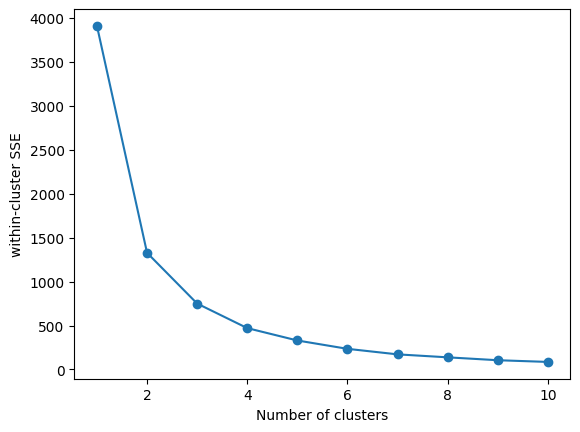

Head of silhouette vals:
 [0.66672844 0.61152073 0.56913471 0.46385566 0.75021757 0.68290063
 0.30506919 0.76554784 0.63523923 0.70844462 0.54683497 0.56913471
 0.71957444 0.76554784 0.66672844 0.61920586 0.70910862 0.51681414
 0.51681414 0.52670136 0.60137739 0.56913471 0.55387411 0.22037138
 0.68290063 0.70910862 0.51681414 0.54683497 0.09124857 0.75021757]

Minimum value: 0.09124856510990971 
Maximum value: 0.7655478375636042 



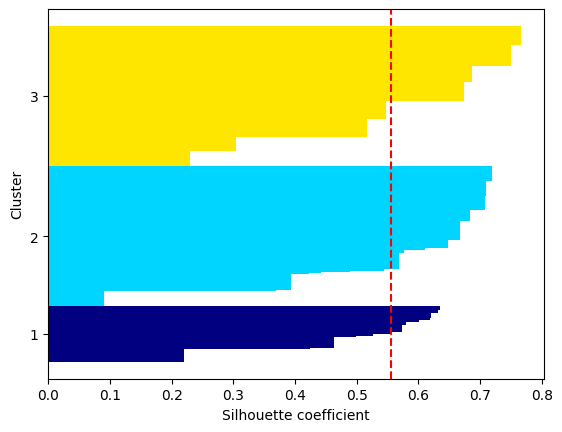

Silhouette_score:  0.5560947439095683


In [8]:
km_base = KMeans(n_clusters=3,
           #init='random',
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=1234)

# predict k-means classes
y_km_base = km_base.fit_predict(rating_values_array_std)

# print cluster predictions
print(y_km_base)
df['cluster_id'] = y_km_base
print('within-cluster SSE: %.2f' % km_base.inertia_)
# initialize within-cluster SSE list
wc_SSE = []

# fit KMeans models with different numbers of clusters
for i in range(1, 11):
    km = KMeans(n_clusters=i,           
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=1e-04,
                random_state=0)
    km.fit(rating_values_array_std)
    wc_SSE.append(km.inertia_)
# plot within-cluster SSE for each k
plt.plot(range(1,11), wc_SSE, marker='o');
plt.xlabel('Number of clusters');
plt.ylabel('within-cluster SSE');
plt.show()

# find silhouette values
silhouette_vals = silhouette_samples(rating_values_array_std, y_km_base, metric = 'euclidean')
print('Head of silhouette vals:\n', silhouette_vals[:30])
print('\nMinimum value:', min(silhouette_vals),
      '\nMaximum value:', max(silhouette_vals), '\n')
#print(silhouette_score(rating_values_array_std, y_km_2, metric = 'euclidean'))
cluster_labels = np.unique(y_km_base)
n_clusters = len(cluster_labels)

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    # grab silhouette values for each cluster
    c_silhouette_vals = silhouette_vals[y_km_base == c]
    c_silhouette_vals.sort()
    # plot y and x axes
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
# plot average value across clusters    
silhouette_vals = silhouette_samples(rating_values_array_std, y_km_base, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster');
plt.xlabel('Silhouette coefficient');
plt.show()

# find silhouette values
silhouette_score = silhouette_score(rating_values_array_std.reshape(-1,1), y_km_base)
print(f'Silhouette_score: ', silhouette_score)

<Axes: xlabel='score_sum', ylabel='Count'>

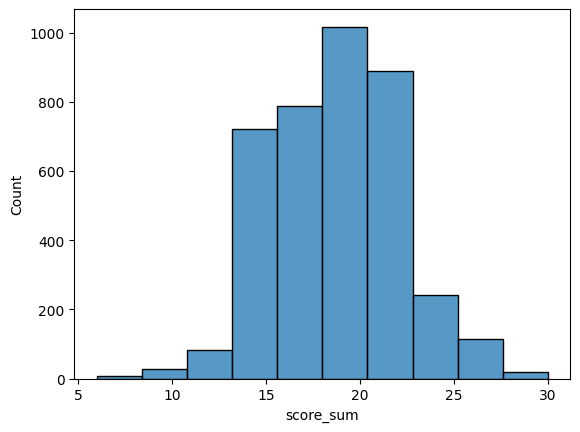

In [18]:
sns.histplot(x='score_sum', data = df, bins = 10)

<Axes: xlabel='score_sum', ylabel='count'>

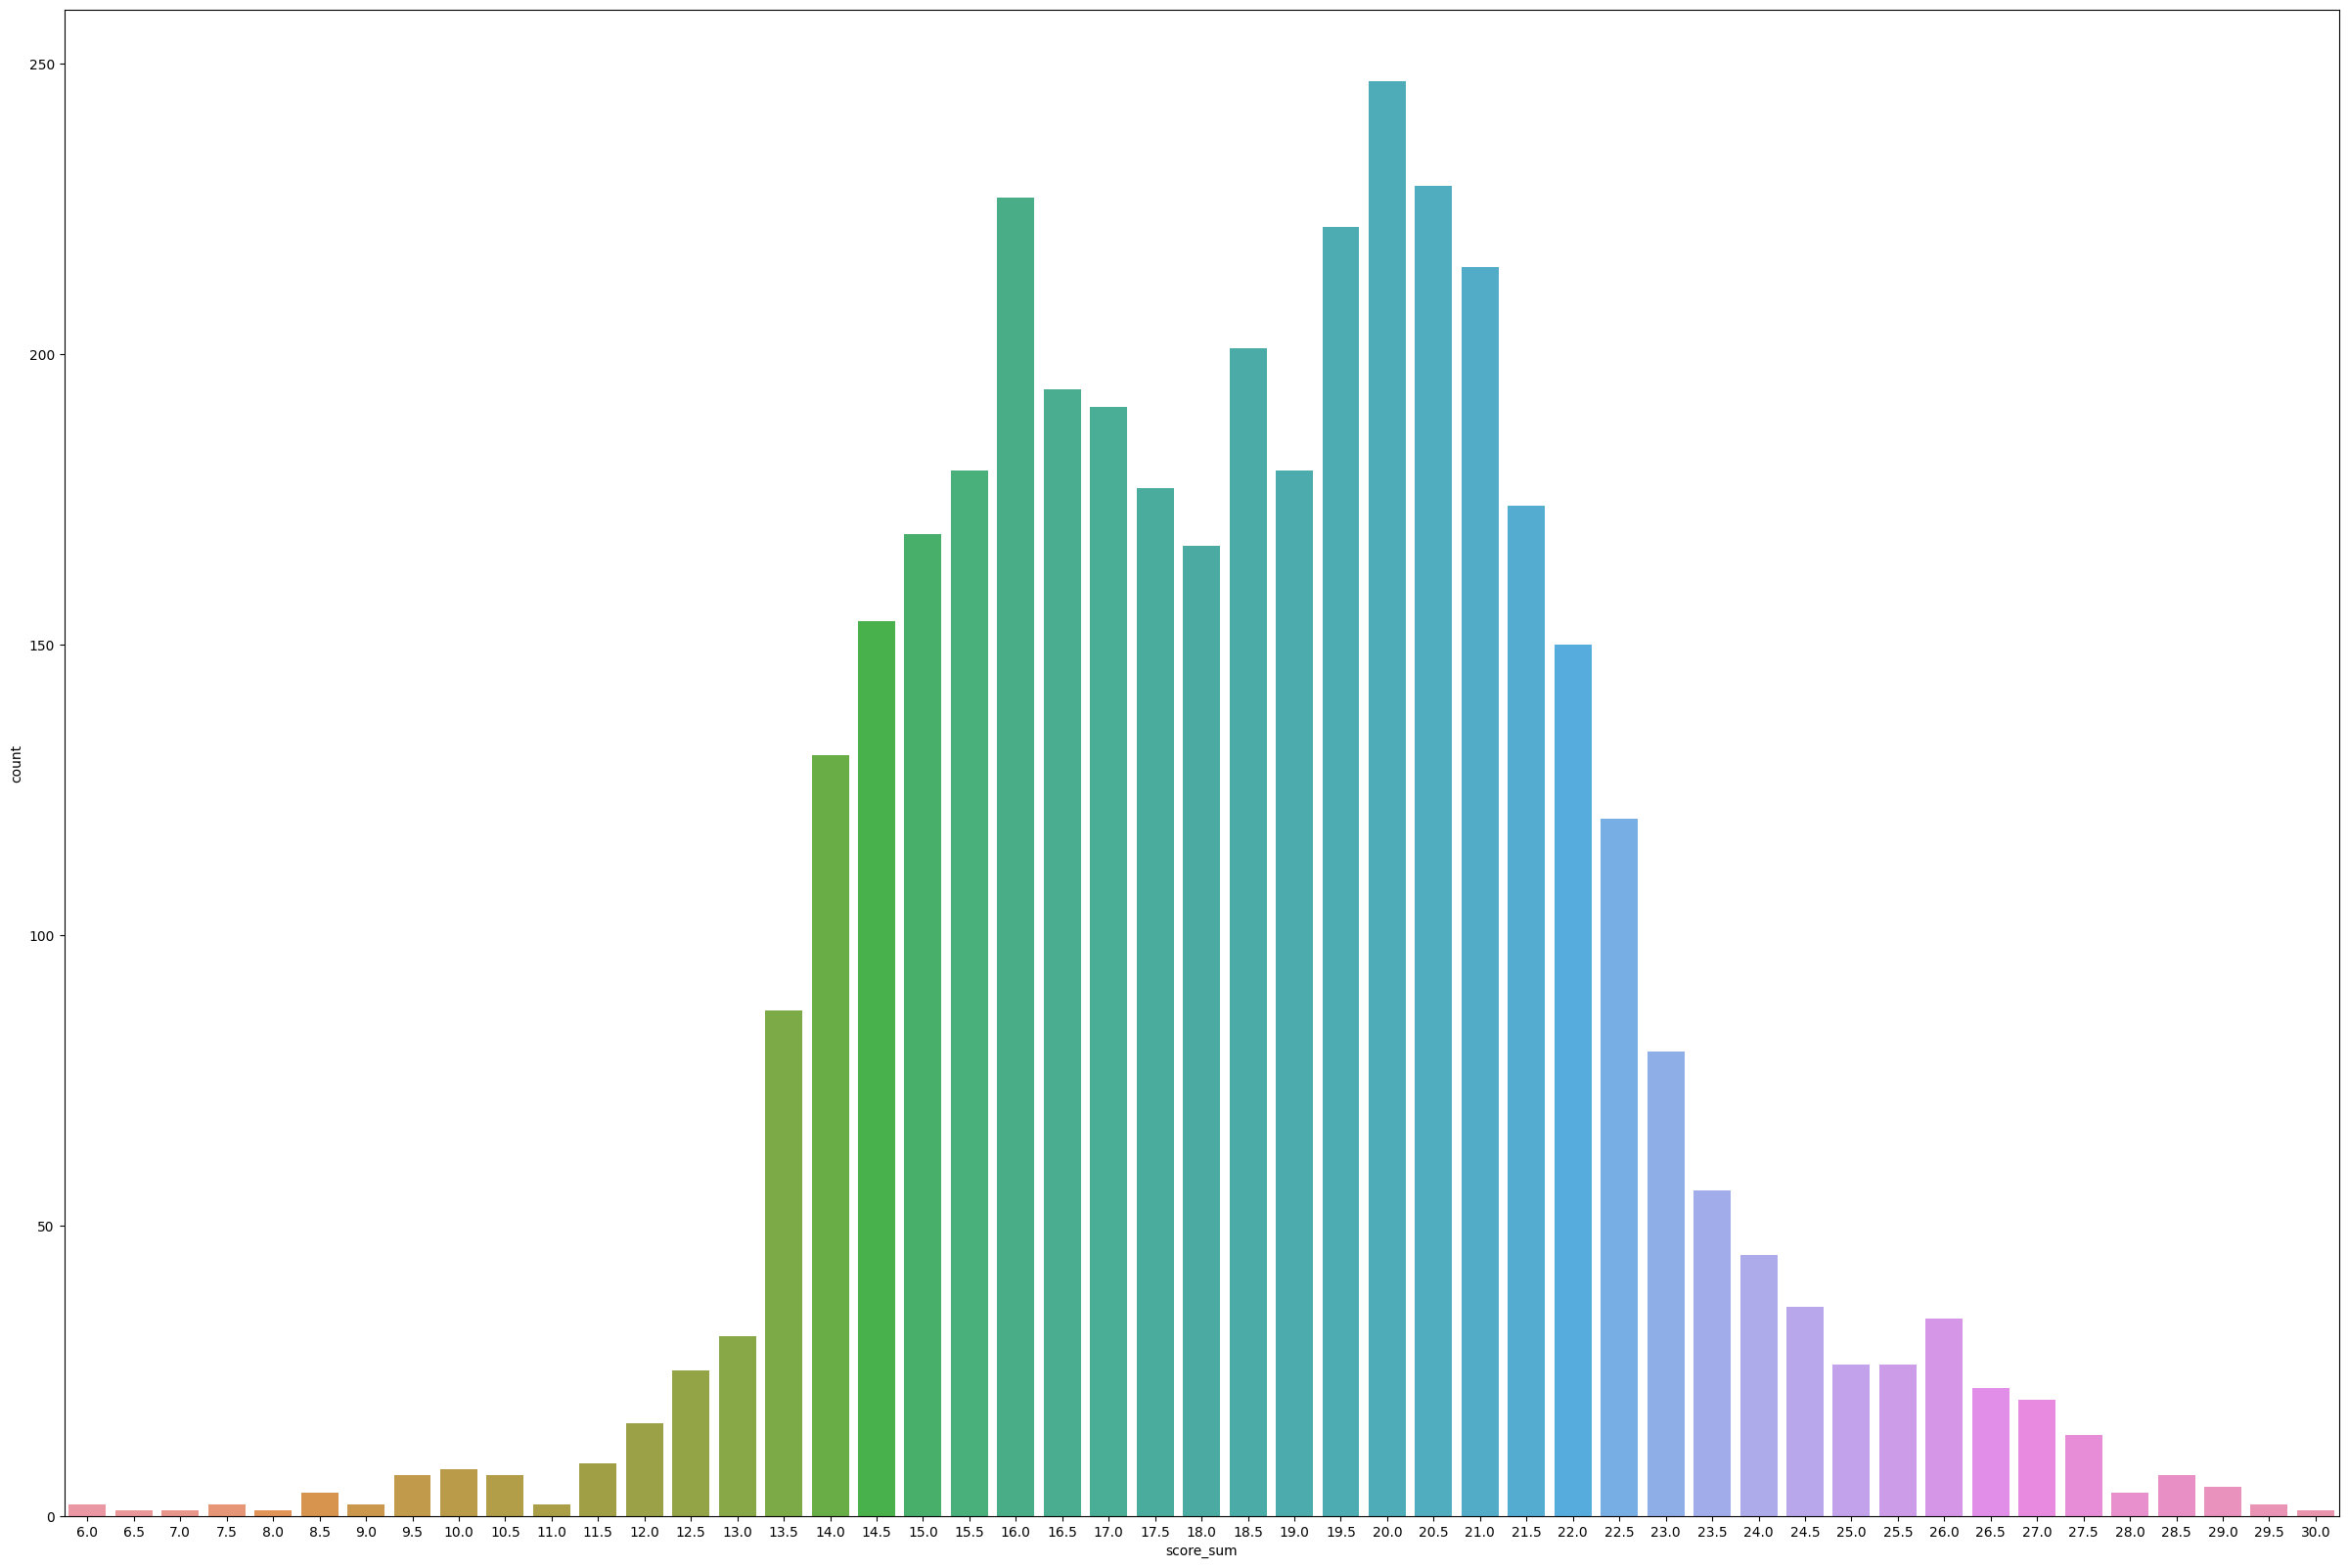

In [19]:
plt.figure(figsize = (30,20))
sns.countplot(x='score_sum', data = df)

In [16]:
df.loc[:, 'fold'] = -1 # Create a new column `fold` containing `-1`s.
df = df.sample(frac=1).reset_index(drop=True) # Shuffle the rows.
targets = df.drop('full_text', axis=1).values # Extract the targets as an array.
mskf = MultilabelStratifiedKFold(n_splits=3)
for fold_, (train_, valid_) in enumerate(mskf.split(X=df[label_cols], y=targets)):
    df.loc[valid_, 'fold'] = fold_
df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,score_sum,fold,cluster_id
0,CC8647F0D1E1,Should the school board add one and a half hou...,3.0,3.5,4.0,3.5,4.0,4.0,22.0,1,0
1,9C9F45A47A92,With can use cell phone in the classroom becau...,2.5,2.0,3.0,2.0,2.0,3.0,14.5,1,1
2,E853D5DD528D,People should be guidance by experts and autho...,3.0,3.0,3.5,2.5,2.0,2.5,16.5,0,1
3,785DBAB78957,One educational activity I like to do is doing...,2.5,2.5,3.5,3.0,3.0,2.0,16.5,2,1
4,838093B60075,Imagination is important than knowledge!\n\nIm...,3.5,3.5,3.5,3.0,4.0,4.0,21.5,2,2
...,...,...,...,...,...,...,...,...,...,...,...
3906,9ED1E2DB0B0F,"If someone wants to grow more as a person, the...",3.0,2.5,3.0,2.5,2.5,3.0,16.5,1,1
3907,F2A97549C778,We live in a world were everything revolves ar...,3.5,3.5,4.0,3.5,3.5,3.5,21.5,2,2
3908,5FC620AEDC8B,"Prime Ministor Winstong Churchill said "" Succe...",3.0,3.0,2.5,2.5,2.5,2.5,16.0,0,1
3909,C6DDE5F881C2,The school cafeteri should change the food to ...,2.5,2.5,2.5,2.5,2.5,2.0,14.5,0,1


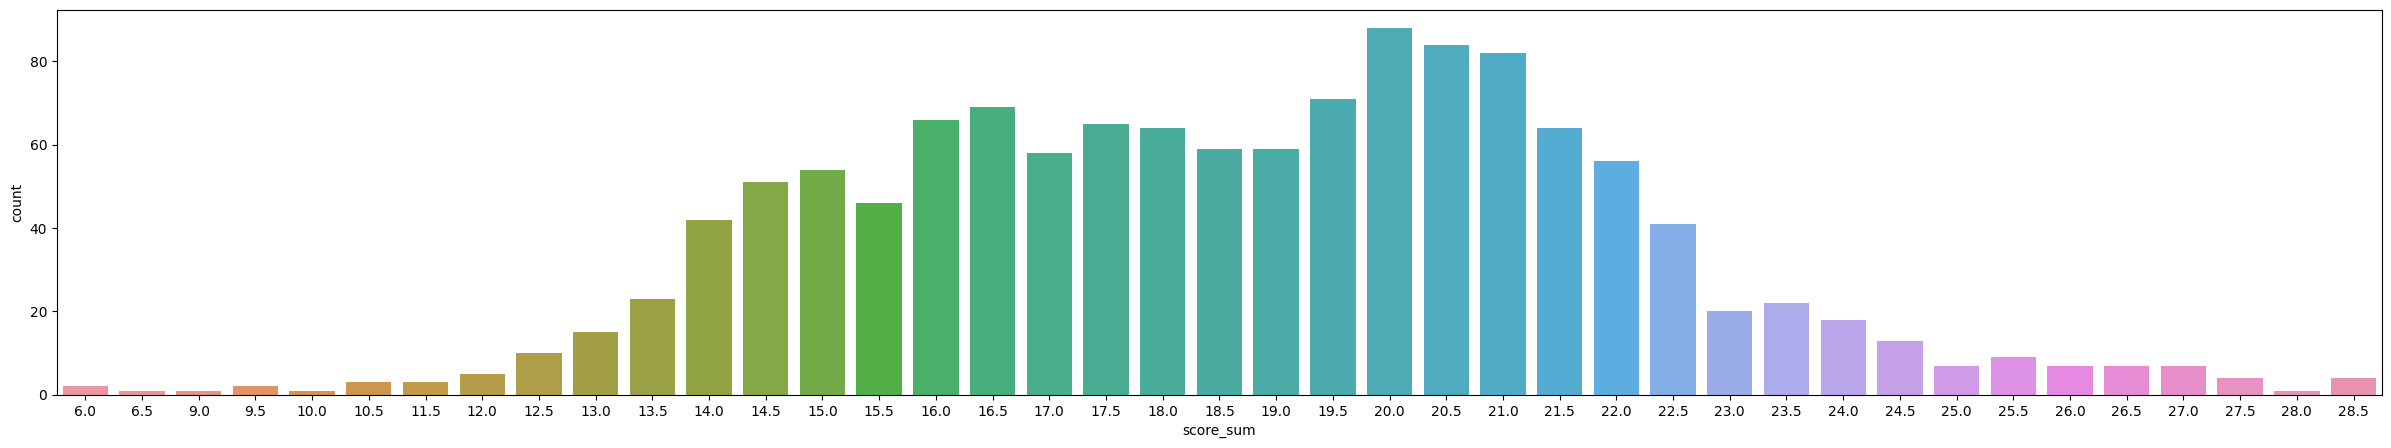

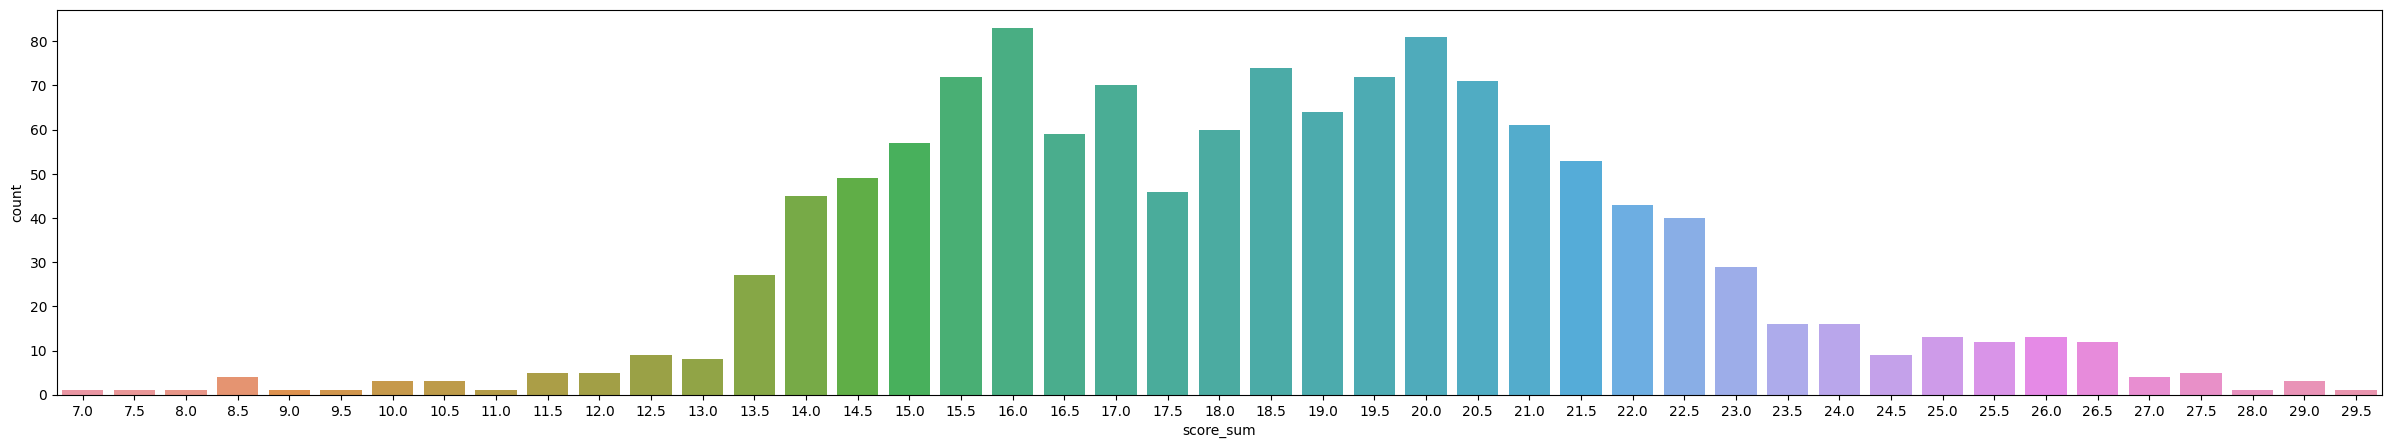

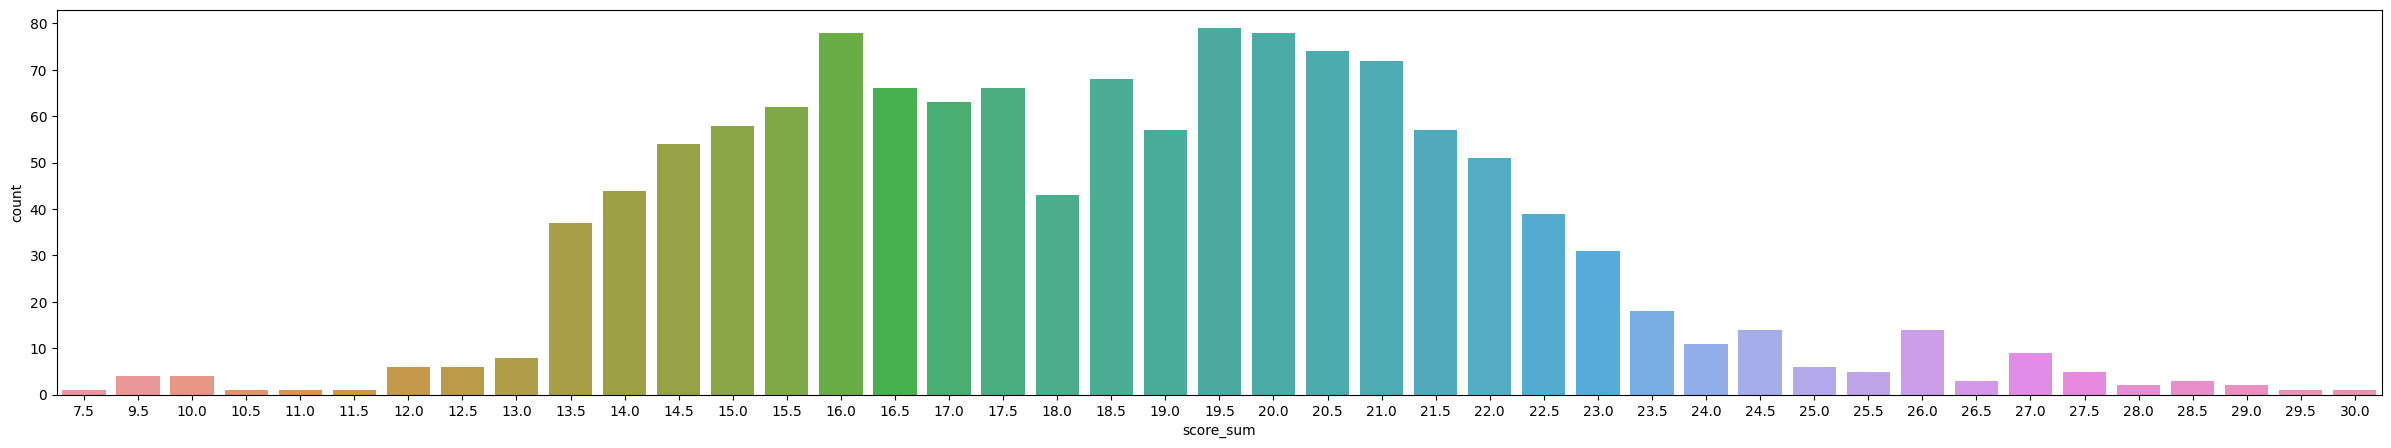

In [23]:
for i in range(0,3):
    plt.figure(figsize = (30,5))
    sns.countplot(x='score_sum', data = df[df.fold == i])
    plt.show(block = False)

In [26]:
df[df['fold'] == 0].head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,score_sum,fold,cluster_id
2,E853D5DD528D,People should be guidance by experts and autho...,3.0,3.0,3.5,2.5,2.0,2.5,16.5,0,1
6,C3E499B46594,Althogh some school districts offer programs t...,3.5,2.5,3.0,3.0,3.0,4.0,19.0,0,2
8,5D7D1445A7CF,Smooth Sails do not make Skillful Sailors!\n\n...,4.5,5.0,5.0,5.0,4.5,4.5,28.5,0,0
10,DDAA14DE7D11,They should be able to work with each other th...,2.5,3.0,2.5,2.5,2.5,3.0,16.0,0,1
12,29FCF6DFFFFC,I believe technology can not be allow in many ...,3.5,3.0,3.5,2.5,3.0,3.0,18.5,0,2
